# CS 634 Final Term Project Implentation



#### Option - II: Deep Learning
#### Name: Shaswat Dharaiya
#### Email: srd22@njit.edu
#### Github: https://github.com/srd22-njit/CS634_Final

## Import the important libraries

In [15]:
# For the Nueral Network
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# For the operations
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## Enable GPU
Enable GPU for faster training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Hyperparameters
Define our hyperparameters for the NN

In [ ]:
input_size = 28
sequence_length = 28
num_layers = 2
hidden_size = 256
num_classes = 2
learning_rate = 0.001
batch_size = 64
num_epochs = 1
n_folds = 10


## Load Dataset

* We first laod the inbuild MNIST dataset, and we devide the data into train & test by specifying `train=True` & `train=False`.
* We then extract images from both train & test data with labels as 0 or 1 (binary classification.)

In [16]:
train_dataset = datasets.MNIST(root='./dataset/', train=True, transform=transforms.ToTensor(), download =True)
test_dataset = datasets.MNIST(root='./dataset/', train=False, transform=transforms.ToTensor(), download =True)

idx = (train_dataset.targets==0) | (train_dataset.targets==1)
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

idx = (test_dataset.targets==0) | (test_dataset.targets==1)
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]


## Dataset
Let's look into what the dataset looks like

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

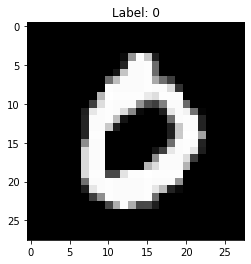

In [32]:
idx = 1
plt.title(f"Label: {test_dataset[idx][1]}")
plt.imshow(test_dataset[idx][0].reshape(28,28), cmap='gray')
print(test_dataset[idx][0].reshape(28,28))

# Concatinate Dataset
We concatinate our datasets so as to make a single dataset out of it. We'll devide them again during K-Fold section.

In [ ]:
dataset = ConcatDataset([train_dataset, test_dataset])

## Define the Nueral Network
Use `nn.Module` in order to use Neural Network with PyTorch.<br>
The `typeRNN` attribute will tell Neural which kind of Neural Network we want to use. Options:
* RNN
* GRU
* LSMT

In [ ]:
# Create an RNN
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes,typeRNN="RNN"):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.typeRNN = typeRNN        
        print(self.typeRNN)
  
  def forward(self, x):    
    if self.typeRNN == "BRNN":
      h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
      out, _ = self.lstm(x, (h0, c0))       
      out = self.fc(out[:, -1, :])
      return out
    
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    if self.typeRNN == "RNN":
      out, _ = self.rnn(x, h0)
    
    if self.typeRNN == "GRU":      
      out, _ = self.gru(x, h0)    

    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)      
    return out

In [ ]:
typeRNN = "BRNN"
model = RNN(input_size, hidden_size, num_layers, num_classes,typeRNN).to(device)

BRNN


## Add Loss & Optimizers
We use `CrossEntropyLoss` as our loss function.<br>
We use `Adam` as our optimizer.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train the model.
We train the model, calculate the accuracy, and design the confusion matrix for each epoch.

* We first devide the dataset back into train & test sets.
* Then we convert into DataLoader class and make batches out of it.
* We feed the data to our model and then train our model.
* We store the predictions along with actual data into `KFOLD_confusion_dict`
  * `KFOLD_confusion_dict` will hold all the data. (ie. predictions and actual results from each fold and each epoch)

In [ ]:
KFOLD_confusion_dict = {}
kfold = KFold(n_splits=n_folds, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  train_dataset1, test_dataset1, confusion_dict = [], [], {}

  for id in train_ids:
    train_dataset1.append(dataset[id])
  for id in test_ids:
    test_dataset1.append(dataset[id])

  train_loader = DataLoader(dataset = train_dataset1, batch_size =batch_size, shuffle=False)
  test_loader = DataLoader(dataset = test_dataset1, batch_size =batch_size, shuffle=False)

  model = RNN(input_size, hidden_size, num_layers, num_classes,typeRNN).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  print('--------------------------------')
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  for epoch in range(num_epochs):
    all_preds = []
    all_y = []
    num_correct = 0
    num_samples = 0
    for data, targets in train_loader:
      # Get data to cuda if possible
      data = data.to(device=device).squeeze(1)
      targets = targets.to(device=device)

      # forward
      scores = model(data)

      _,predictions = scores.max(1)
      all_preds = all_preds + [item.item() for item in predictions]
      all_y = all_y + [item.item() for item in targets]

      num_correct += (predictions == targets).sum()
      num_samples += predictions.size(0)    

      loss = criterion(scores, targets)

      # backward
      optimizer.zero_grad()
      loss.backward()

      # gradient descent or adam step
      optimizer.step()
    print(f"Epoch: {epoch} - Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    confusion_dict[epoch] = pd.DataFrame(list(zip(all_preds,all_y)), columns=["Predicted","Actual"])
  KFOLD_confusion_dict[fold] = confusion_dict

BRNN
--------------------------------
FOLD 0
--------------------------------
Epoch: 0 - Got 13018 / 13302 with accuracy 97.86
BRNN
--------------------------------
FOLD 1
--------------------------------
Epoch: 0 - Got 12943 / 13302 with accuracy 97.30
BRNN
--------------------------------
FOLD 2
--------------------------------
Epoch: 0 - Got 13039 / 13302 with accuracy 98.02
BRNN
--------------------------------
FOLD 3
--------------------------------
Epoch: 0 - Got 12956 / 13302 with accuracy 97.40
BRNN
--------------------------------
FOLD 4
--------------------------------
Epoch: 0 - Got 12987 / 13302 with accuracy 97.63
BRNN
--------------------------------
FOLD 5
--------------------------------
Epoch: 0 - Got 12969 / 13302 with accuracy 97.50
BRNN
--------------------------------
FOLD 6
--------------------------------
Epoch: 0 - Got 13034 / 13302 with accuracy 97.99
BRNN
--------------------------------
FOLD 7
--------------------------------
Epoch: 0 - Got 13002 / 13302 with

## Store the data

Stores/Pickles the data to file

In [ ]:
with open('/content/drive/MyDrive/Sem 1/DM/KFOLD_confusion_dict.pickle', 'wb') as handle:
    pickle.dump(KFOLD_confusion_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/Sem 1/DM/KFOLD_confusion_dict.pickle', 'rb') as handle:
    KFOLD_confusion_dict = pickle.load(handle)

In [ ]:
KFOLD_confusion_dict[0][0]

,Predicted,Actual
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
13297,1,1
13298,0,0
13299,1,1
13300,0,0


# Confusion Matrix & Performance Evaluation

## Confusion Matrix
We use our predictions from each fold and plot the confusion matrix.

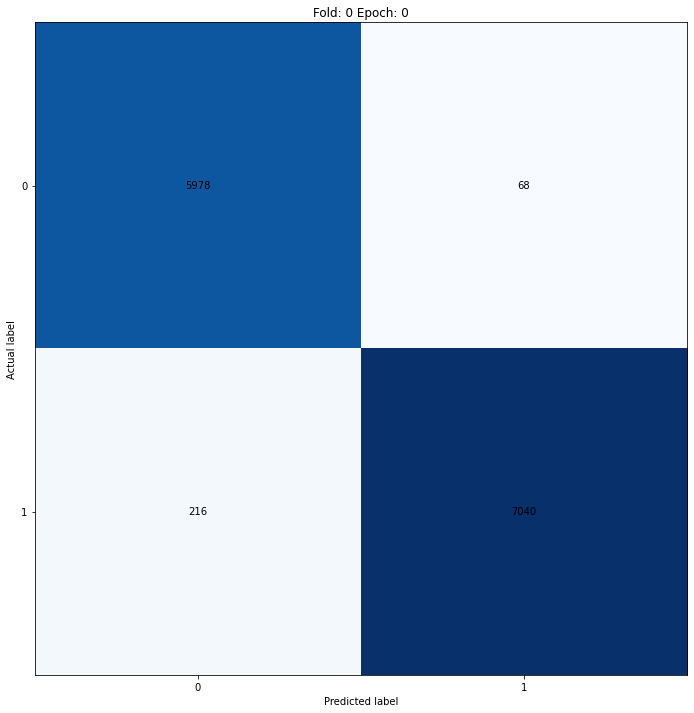

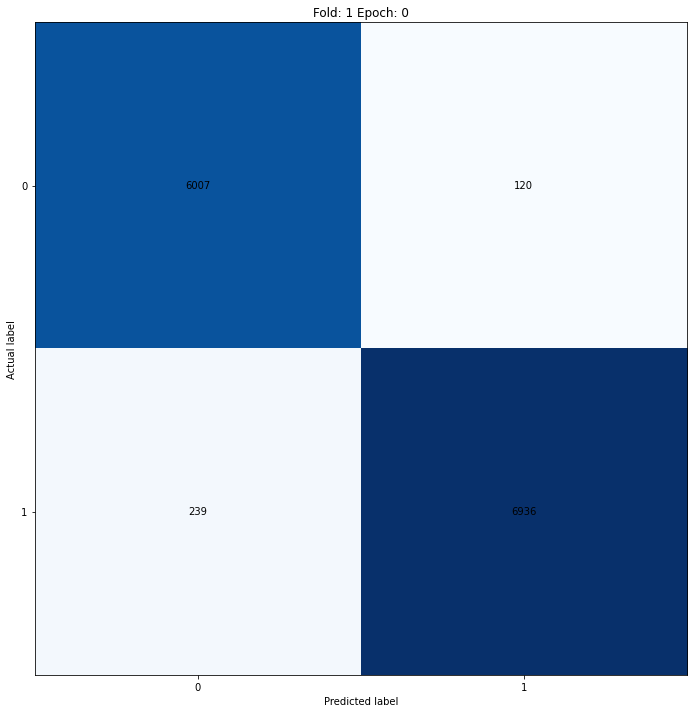

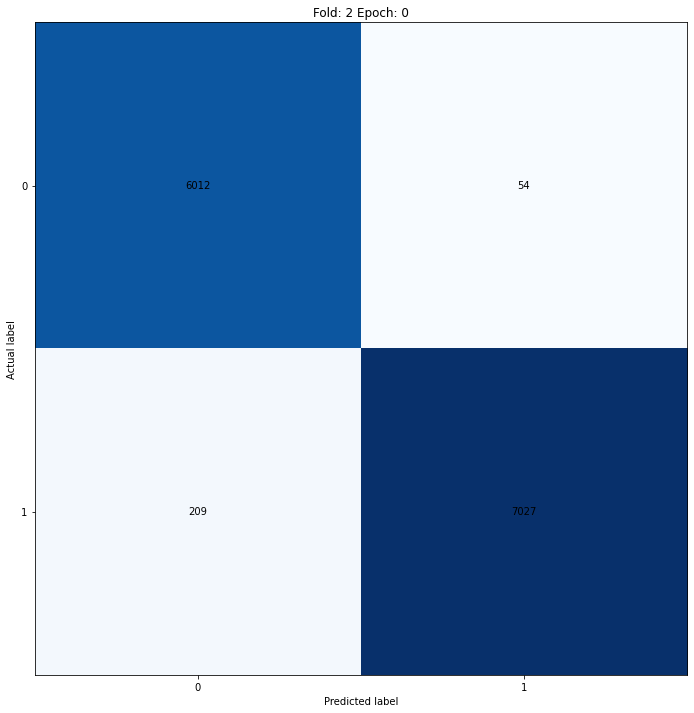

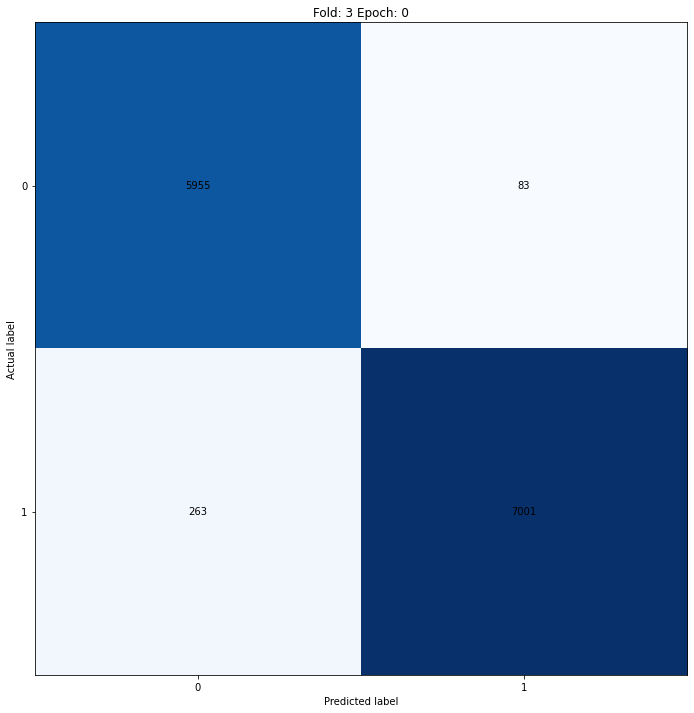

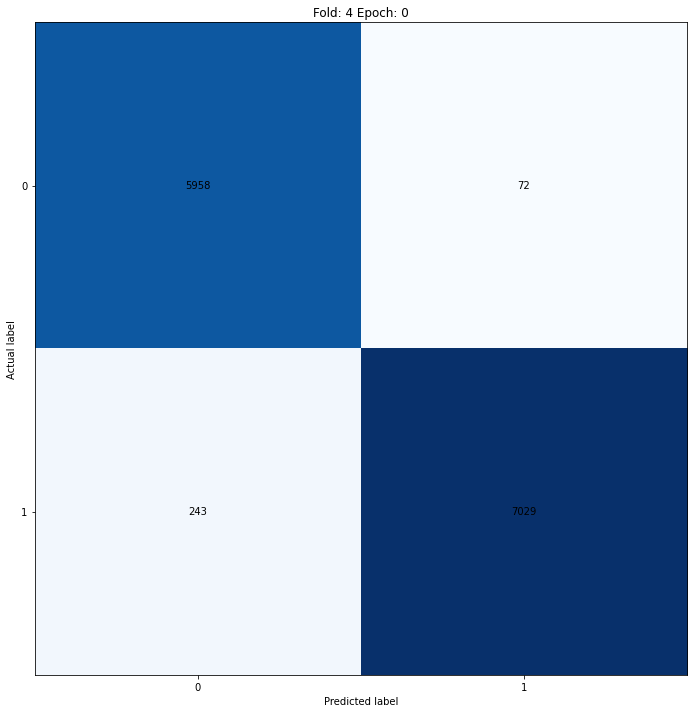

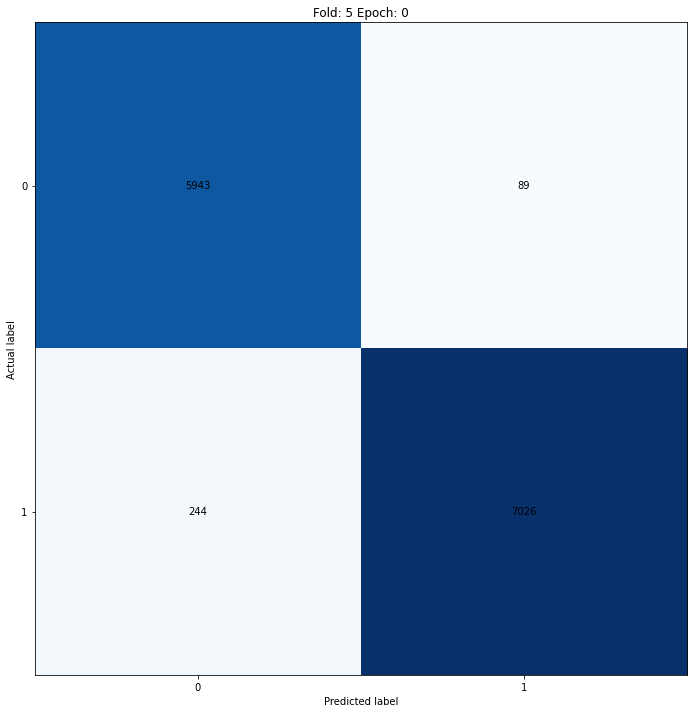

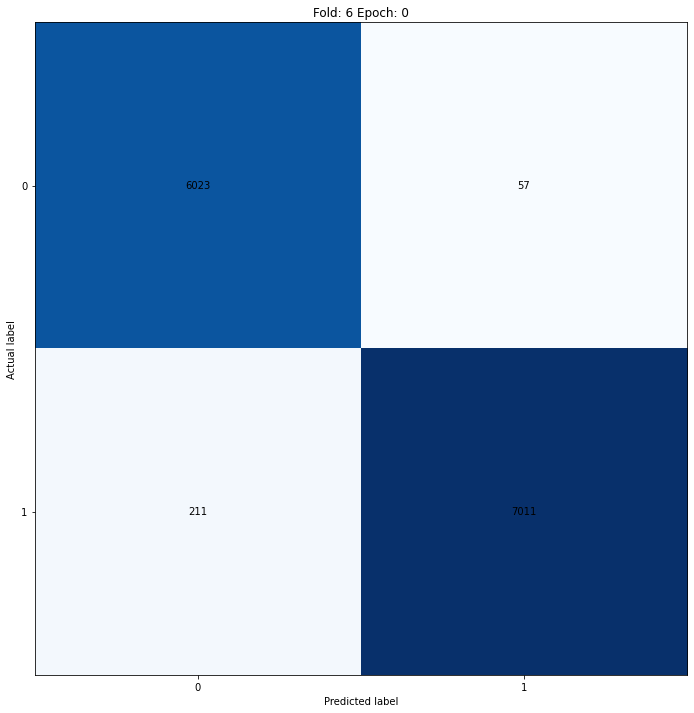

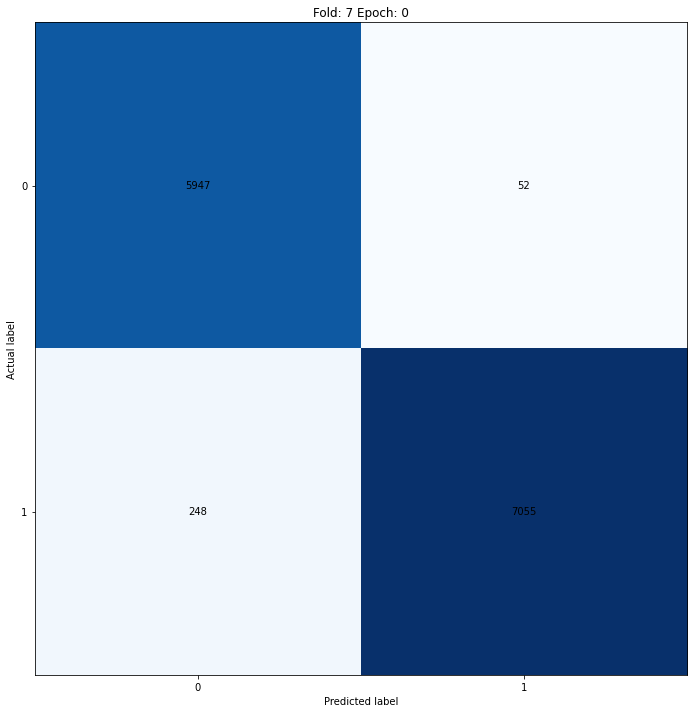

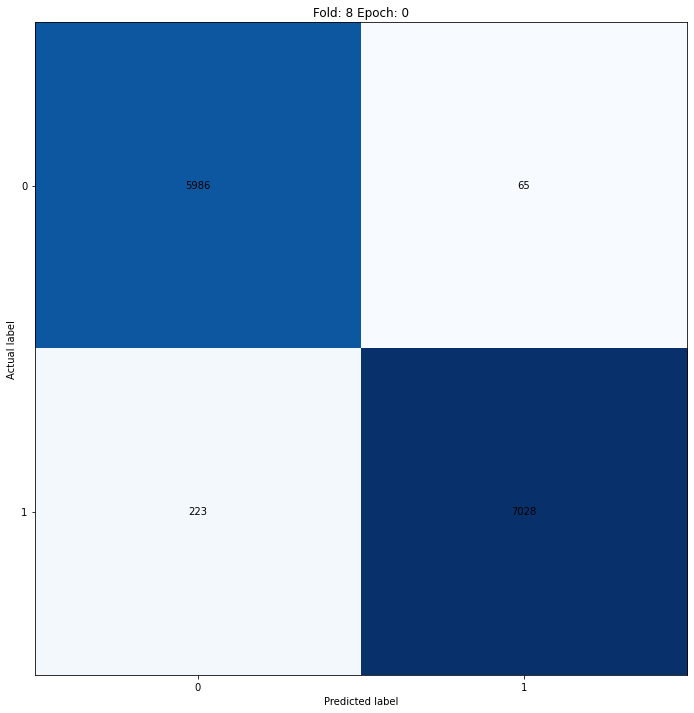

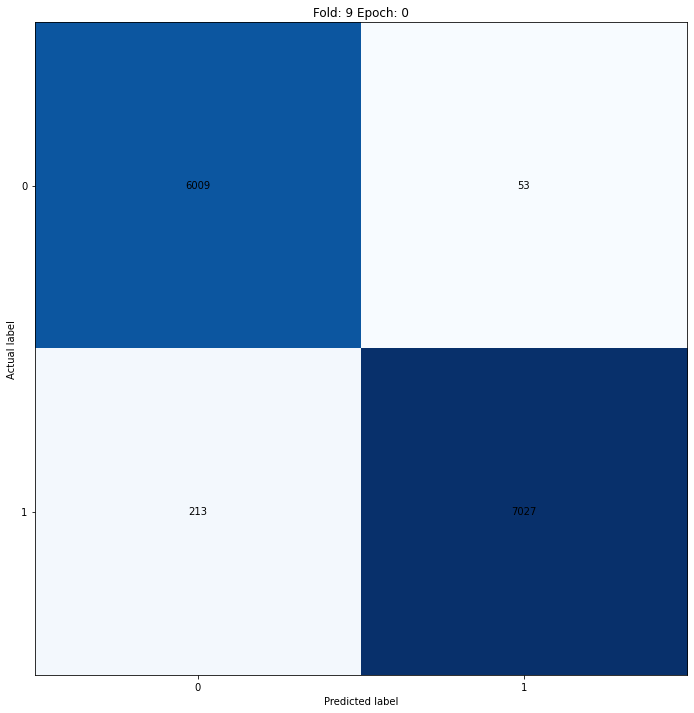

In [ ]:
from sklearn.metrics import confusion_matrix
for fold, confusion_dict in  KFOLD_confusion_dict.items():
  for key, val in confusion_dict.items():
    cm = confusion_matrix(val['Predicted'], val["Actual"])
    fig, ax = plt.subplots(figsize=(14,12))         # Sample figsize in inches
    plt.imshow(cm,interpolation='none',cmap='Blues')
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, z, ha='center', va='center')
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.title(f"Fold: {fold} Epoch: {key}")
plt.show()

## Evaluating Classifier Performance
![title](Classifier.png)

In [ ]:
def all_conf_matrix():
  matrix_fold = {}
  for fold, confusion_dict in  KFOLD_confusion_dict.items():
    all_matrix = {}
    for epoch, value in confusion_dict.items():  
      # print(f"\nFor fold {fold} & For epoch {epoch}")
      
      p = int(value[(value["Actual"] == 1)]['Actual'].count())
      n = int(value[(value["Actual"] == 0)]['Actual'].count())

      tp = int(value[(value["Predicted"] == 1) & (value["Actual"] == 1)]['Predicted'].count())
      tn = int(value[(value["Predicted"] != 1) & (value["Actual"] != 1)]['Predicted'].count())
      fp = int(value[(value["Predicted"] == 1) & (value["Actual"] != 1)]['Predicted'].count())
      fn = int(value[(value["Predicted"] != 1) & (value["Actual"] == 1)]['Predicted'].count())

      tpr = round(tp/(tp + fn), 2)
      tnr = round(tn/(tn + fp), 2)
      fpr = round(fp/(tn + fp), 2)
      fnr = round(fn/(tp + fn), 2)

      recall = round(tp/p, 2)
      precision = round(tp/(tp+fp), 2)
      f1_score = round((2 * recall * precision)/(recall + precision), 2)
      acc = round((tp + tn)/(p + n), 2)
      err_rate = round((fp + fn)/(p + n), 2)
    
      headings = ["Positives", "Negatives",
                  "True Positives", "True Negatives", "False Positives", "False Negatives",
                  "True Positive Rate", "True Negative Rate", "False Positive Rate", "False Negative Rate",
                  "Recall or Sensitivity", "Precision", "F1 Score", "Accuracy", "Error Rate"
                  ]
      values = [p, n, tp, tn, fp, fn, tpr, tnr, fpr, fnr, recall, precision, f1_score, acc, err_rate]
      matrix = pd.DataFrame(values, columns = [f"Fold {fold}"], index=headings)

      all_matrix[epoch] = matrix
    matrix_fold[fold] = all_matrix
  return matrix_fold

In [ ]:
all_matrices = all_conf_matrix()
final_matrix = pd.DataFrame()
for fold, matrix in all_matrices.items():
  for epoch, pd_matrix in matrix.items():
    # print(f"\nConfusion Matrix for fold: {fold} epoch: {epoch}\n")
    # print(f"{pd_matrix}")
    final_matrix = pd.concat([final_matrix, pd_matrix], axis = 1)

final_matrix["Average"] = final_matrix.mean(axis=1)

## Display Evaluating Classifier Performance

In [ ]:
final_matrix

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Average
Positives,7108.00,7056.00,7081.00,7084.00,7101.00,7115.00,7068.00,7107.00,7093.00,7080.00,7089.300
Negatives,6194.00,6246.00,6221.00,6218.00,6201.00,6187.00,6234.00,6195.00,6209.00,6222.00,6212.700
True Positives,7040.00,6936.00,7027.00,7001.00,7029.00,7026.00,7011.00,7055.00,7028.00,7027.00,7018.000
True Negatives,5978.00,6007.00,6012.00,5955.00,5958.00,5943.00,6023.00,5947.00,5986.00,6009.00,5981.800
False Positives,216.00,239.00,209.00,263.00,243.00,244.00,211.00,248.00,223.00,213.00,230.900
False Negatives,68.00,120.00,54.00,83.00,72.00,89.00,57.00,52.00,65.00,53.00,71.300
True Positive Rate,0.99,0.98,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.989
True Negative Rate,0.97,0.96,0.97,0.96,0.96,0.96,0.97,0.96,0.96,0.97,0.964
False Positive Rate,0.03,0.04,0.03,0.04,0.04,0.04,0.03,0.04,0.04,0.03,0.036
False Negative Rate,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.011


![title](final_matrix.png)